In [81]:
import sys,os
srcpath = "C:/Users/Caroline Wang/src/risk-slim-11-11-18"
sys.path.insert(0, srcpath)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
from utils import expand_grid
from pprint import pprint

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle


import cplex as cplex
from riskslim.helper_functions import load_data_from_csv, print_model
from riskslim.setup_functions import get_conservative_offset
from riskslim.coefficient_set import CoefficientSet
from riskslim.lattice_cpa import setup_lattice_cpa, finish_lattice_cpa

## RiskSLIM 

Data Processing

In [72]:
%%capture

train_name = "train_stumps"                                      
test_name = "test_stumps"                                      # name of the data

# data_dir = os.getcwd()                                      # directory where datasets are stored
data_dir = "../data/"      #new change unsure if works        # directory where datasets are stored

train_csv = data_dir + train_name + ".csv"     # csv file for the train dataset
test_csv = data_dir + test_name  + ".csv"         # csv file for the test dataset

#data formatted for our own eval functions
train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)
X_train, Y_train = train.iloc[:,1:], train.iloc[:,0].values
X_test, Y_test = test.iloc[:,1:], test.iloc[:,0].values

#data formatted for riskSLIM
#we utilize the riskSLIM's data processing function for debugging purposes
riskslim_train = load_data_from_csv(dataset_csv_file = train_csv)


In the stumps dataset, for age vars, have values eighteen, nineteen, twenty, twenty1, twenty2, twenty3, twenty4, twenty6, twenty8, thirty, thirty2, thirty4, thirty6, thirty8, forty, forty4, forty8, fifty2, fifty6, sixty, sixty5. 

In [73]:
#select a subset of features to work with
adaboost_subset = ["p_current_age_eighteen","p_current_age_twenty2", "p_current_age_twenty6", "p_current_age_thirty2",
                   "p_current_age_forty", "p_current_age_forty8", "p_current_age_sixty",
#                     "p_age_first_offense_thirty8", "p_age_first_offense_thirty", "p_age_first_offense_sixty",
                    "fail_appear_two_plus_one", "fail_appear_two_plus_five",
                    "fail_appear_two_yr_one", "fail_appear_two_yr_five",
#                     "is_misdem_one", #boolean variable
                    "p_arrest_one","p_arrest_five", "p_arrest_nine", 
                    "p_charge_one", "p_charge_five", 
                    "p_charge_violent_one", "p_charge_violent_five", 
                    "p_drug_one", "p_drug_five",
                    "p_juv_fel_count_one", "p_juv_fel_count_seven", 
                    "p_misdem_count_person_one", "p_misdem_count_person_nine", 
                    "p_misdemassault_arrest_one", "p_misdemassault_arrest_five",
                     "p_murder_arrest_one", "p_murder_arrest_five", 
                     "p_n_on_probation_one", "p_n_on_probation_five",
                    "p_prison_one", "p_prison_five",
                     "p_probation_three", "p_probation_four", "p_probation_six", "p_probation_seven", 
                    "p_property_one", "p_property_eight", 
                    "p_sex_arrest_two","p_sex_arrest_six", "p_sex_arrest_seven",
                    "p_stalking_one", "p_stalking_five",
                    "p_weapons_arrest_one", "p_weapons_arrest_five", 
                    "prior_conviction_M_one", "prior_conviction_M_seven"]

#select subset of features for data
X_train, X_test = X_train[adaboost_subset].values, X_test[adaboost_subset].values

#change labels to 1 and 0 
Y_train[Y_train == -1] = 0
Y_test[Y_test == -1] = 0

#select subset of features for riskslim formatted training data 
intercept_col = np.ones(X_train.shape[0])
intercept_col.shape = (X_train.shape[0],1)
riskslim_train['X'] = np.hstack((intercept_col, X_train))
riskslim_train['variable_names'] = ['(Intercept)'] + adaboost_subset
print(riskslim_train)

{'X': array([[1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 1.]]), 'Y': array([[ 1],
       [ 1],
       [-1],
       ...,
       [-1],
       [-1],
       [ 1]], dtype=int64), 'variable_names': ['(Intercept)', 'p_current_age_eighteen', 'p_current_age_twenty2', 'p_current_age_twenty6', 'p_current_age_thirty2', 'p_current_age_forty', 'p_current_age_forty8', 'p_current_age_sixty', 'fail_appear_two_plus_one', 'fail_appear_two_plus_five', 'fail_appear_two_yr_one', 'fail_appear_two_yr_five', 'p_arrest_one', 'p_arrest_five', 'p_arrest_nine', 'p_charge_one', 'p_charge_five', 'p_charge_violent_one', 'p_charge_violent_five', 'p_drug_one', 'p_drug_five', 'p_juv_fel_count_one', 'p_juv_fel_count_seven', 'p_misdem_count_person_one', 'p_misdem_count_person_nine', 'p_misdemassault_arrest_one', 'p_misdemassault_arrest_five'

Tips from Berk on riskSLIm:     
    
    1. to add a constraint like "either "CellSize" or "CellShape"
    you must formulate the constraint in terms of the alpha variables
    alpha[cell_size] + alpha[cell_shape] <= 1 to MIP
    mip.linear_constraints.add(
            names = ["EitherOr_CellSize_or_CellShape"],
            lin_expr = [cplex.SparsePair(ind = get_alpha_ind(['UniformityOfCellSize', 'UniformityOfCellShape']),
                                         val = [1.0, 1.0])],
            senses = "L",
            rhs = [1.0])
            
    2. to add a constraint like "either "CellSize" or "CellShape"
       you must formulate the constraint in terms of the alpha variables
       alpha[cell_size] + alpha[cell_shape] <= 1 to MIP
       mip.linear_constraints.add(
             names = ["EitherOr_CellSize_or_CellShape"],
             lin_expr = [cplex.SparsePair(ind = get_alpha_ind(['UniformityOfCellSize', 'UniformityOfCellShape']),
                                          val = [1.0, 1.0])],
             senses = "L",
             rhs = [1.0])



In [68]:
def fit_riskSLIM(data, params): 
    '''
    @param data = {
        "X": train, (ndarray)
        "Y": test,  (ndarray)
        "sample_weights": sample_weights
        "variable_names": variable_names
    }
    @param params: dictionary containing parameters 
    '''

    settings = {
        # Problem Parameters
        'c0_value': params['c0_value'],
        'w_pos': params['w_pos'],
        #
        # LCPA Settings
        'max_runtime': params['max_runtime'],                               # max runtime for LCPA
        'max_tolerance': np.finfo('float').eps,             # tolerance to stop LCPA (set to 0 to return provably optimal solution)
        'display_cplex_progress': False,                     # print CPLEX progress on screen
        'loss_computation': 'normal',                       # how to compute the loss function ('normal','fast','lookup')
        #
        # RiskSLIM MIP settings
        'drop_variables': False,
        #
        # LCPA Improvements
        'round_flag': False,                                # round continuous solutions with SeqRd
        'polish_flag': False,                               # polish integer feasible solutions with DCD
        'chained_updates_flag': False,                      # use chained updates
        'initialization_flag': False,                       # use initialization procedure
        'init_max_runtime': 300.0,                          # max time to run CPA in initialization procedure
        'add_cuts_at_heuristic_solutions': True,            # add cuts at integer feasible solutions found using polishing/rounding
        #
        # CPLEX Solver Parameters
        'cplex_randomseed': 0,                              # random seed
        'cplex_mipemphasis': 0,                             # cplex MIP strategy
    }

    # # turn on at your own risk
    # settings['round_flag'] = False
    # settings['polish_flag'] = False
    # settings['chained_updates_flag'] = False
    # settings['initialization_flag'] = False
    N, P = data["X"].shape

    # create coefficient set and set the value of the offset parameter
    coef_set = CoefficientSet(variable_names=data['variable_names'], lb=params['min_coefficient'], ub=params['max_coefficient'], sign=1)
    conservative_offset = get_conservative_offset(data, coef_set, int(params['max_L0_value']))
    max_offset = min(params['max_offset'], conservative_offset)
    
    coef_set['(Intercept)'].ub = max_offset
    coef_set['(Intercept)'].lb = -max_offset

    # create constraint
    trivial_L0_max = P - np.sum(coef_set.C_0j == 0)
    max_L0_value = min(int(params['max_L0_value']), trivial_L0_max)

    constraints = {
        'L0_min': 0,
        'L0_max': max_L0_value,
        'coef_set':coef_set,
    }

    # initialize MIP for lattice CPA
    mip_objects = setup_lattice_cpa(data, constraints, settings)

    # add operational constraints
    mip, indices = mip_objects['mip'], mip_objects['indices']
    get_alpha_name = lambda var_name: 'alpha_' + str(data['variable_names'].index(var_name))
    get_alpha_ind = lambda var_names: [get_alpha_name(v) for v in var_names]


    mip_objects['mip'] = mip

    # pass MIP back to lattice CPA so that it will solve
    model_info, mip_info, lcpa_info = finish_lattice_cpa(data, constraints, mip_objects, settings)
    #model_info contains the actual model
    return model_info, mip_info, lcpa_info

In [69]:
def riskslim_prediction(X, model_info, subtraction_score):
    """
    @parameters
    X: test input features (array)
    model_info: output from RiskSLIM model
    subtraction_score: the score used to calculate probability
    """
    
    ## initialize parameters
    dictionary = {}
    prob = np.zeros(len(X))
    scores = np.zeros(len(X))
    
    ## prepare statistics
    coefs = model_info['solution'][1:]
    index = np.where(coefs != 0)[0]
    
    nonzero_coefs = coefs[index]
    features = cols[index]
    X_sub = X[:,index]
    
    ## build dictionaries
    for i in range(len(index)):
        feature_name = features[i]
        coef = nonzero_coefs[i]
        dictionary.update({feature_name: coef})
        
    ## calculate probability
    for i in range(len(X_sub)):
        summation = 0
        for j in range(len(features)):
            a = X_sub[i,j]
            summation += dictionary[features[j]] * a
    
        scores[i] = summation
    
    prob = 1/(1+np.exp(-(scores - subtraction_score)))
    
    return prob

def riskslim_accuracy(X, Y, model_info, subtraction_score, threshold=0.5):
    
    prob = riskslim_prediction(X, model_info, subtraction_score)
    pred = np.mean((prob > threshold) == Y)
    
    return pred

Code to actually run riskSLIM

In [74]:
# problem parameters
params = {
    "max_coefficient" : 10,                                        # value of largest/smallest coefficient
    "min_coefficient" : 0,                                         # sets the lower bound on the coeffs
    "max_L0_value" : 6,                                            
    "max_offset" : 50,                                             # maximum value of offset parameter (optional)
    "c0_value" : 1e-6,                                             # L0-penalty parameter such that c0_value > 0; larger values -> sparser models; we set to a small value (1e-6) so that we get a model with max_L0_value terms
    "w_pos" : 1.00,                                                # relative weight on examples with y = +1; w_neg = 1.00 (optional)
    "max_runtime": 900
    }

model_info, mip_info, lcpa_info = fit_riskSLIM(riskslim_train , params)
print_model(model_info['solution'], riskslim_train)

setting c0 = 0.0 to ensure that intercept is not penalized
05/25/19 @ 05:15 PM | switching loss computation from normal to lookup
05/25/19 @ 05:15 PM | 961 rows in lookup table
05/25/19 @ 05:15 PM | switching loss computation from normal to lookup
05/25/19 @ 05:15 PM | 961 rows in lookup table
PREDICT STRING:  Pr(RECID_USE = +1) = 1/(1 + exp(-3 - score)  TOTAL STRING:  ADD POINTS FROM ROWS 1 to 6  RHO_NAMES:  ['p_probation_seven', 'p_arrest_one', 'p_current_age_twenty6', 'fail_appear_two_yr_one', 'p_charge_violent_five', 'prior_conviction_M_seven']
+-----------------------------------------------+------------------+-----------+
| Pr(RECID_USE = +1) = 1/(1 + exp(-3 - score)   |                  |           |
| ============================================= | ================ | ========= |
| p_probation_seven                             |         4 points |   + ..... |
| p_arrest_one                                  |         2 points |   + ..... |
| p_current_age_twenty6                 

In [75]:
subtraction_score = 3
riskslim_accuracy(X_test, Y_test, model_info, subtraction_score)

0.6058981233243967

## Cross validation

In [77]:
n_folds = 5
params = {
    "max_coefficient" : 10,                                        # value of largest/smallest coefficient
    "min_coefficient" : 0,                                         # sets the lower bound on the coeffs
    "max_L0_value" : 6,                                            
    "max_offset" : 50,                                             # maximum value of offset parameter (optional)
    "c0_value" : 1e-6,                                             # L0-penalty parameter such that c0_value > 0; larger values -> sparser models; we set to a small value (1e-6) so that we get a model with max_L0_value terms
    "w_pos" : 1.00,                                                # relative weight on examples with y = +1; w_neg = 1.00 (optional)
    "max_runtime": 300
    }

cv = KFold(n_splits=n_folds, random_state=816, shuffle=True)
results = []
x_train_agg, x_test_agg = [], []
y_train_agg, y_test_agg = [], []
model_information = []

for train_inds, test_inds in cv.split(riskslim_train['X'], riskslim_train['Y']):
    
    ## subset train data & store test data
#     X_train, Y_train = riskslim_train['X'][train_inds], riskslim_train['Y'][train_inds]
    X_test, Y_test = riskslim_train['X'][test_inds], riskslim_train['Y'][test_inds]
#     sample_weights_train = sample_weights[train_inds]
#     sample_weights_test = sample_weights[test_inds]
    
    train_fold = {
        "X": riskslim_train['X'][train_inds],  #features
        "Y": riskslim_train['Y'][train_inds],  #labels
        "sample_weights":  riskslim_train['sample_weights'][train_inds],
        "variable_names":  riskslim_train['variable_names'], 
        "outcome_name": riskslim_train['outcome_name']
    }

    x_train_agg.append(train_fold["X"])
    y_train_agg.append(train_fold["Y"])
    
    x_test_agg.append(X_test)
    y_test_agg.append(Y_test)


#     ## create new data dictionary
#     new_train_data = {
#         'X': X_train,
#         'Y': Y_train,
#         'variable_names': variable_names,
#         'outcome_name': outcome_name,
#         'sample_weights': sample_weights_train
#     }
        
    ## fit the model
    model_info, mip_info, lcpa_info = fit_riskSLIM(train_fold , params)
    model_information.append(model_info)
    print_model(model_info['solution'], train_fold)

setting c0 = 0.0 to ensure that intercept is not penalized
05/25/19 @ 05:56 PM | switching loss computation from normal to lookup
05/25/19 @ 05:56 PM | 931 rows in lookup table
05/25/19 @ 05:56 PM | switching loss computation from normal to lookup
05/25/19 @ 05:56 PM | 931 rows in lookup table
PREDICT STRING:  Pr(RECID_USE = +1) = 1/(1 + exp(-2 - score)  TOTAL STRING:  ADD POINTS FROM ROWS 1 to 5  RHO_NAMES:  ['p_juv_fel_count_seven', 'p_probation_seven', 'p_current_age_thirty2', 'p_misdem_count_person_one', 'p_misdem_count_person_nine']
+-----------------------------------------------+-------------------+-----------+
| Pr(RECID_USE = +1) = 1/(1 + exp(-2 - score)   |                   |           |
| ============================================= | ================= | ========= |
| p_juv_fel_count_seven                         |         10 points |   + ..... |
| p_probation_seven                             |          2 points |   + ..... |
| p_current_age_thirty2                       

In [78]:
subtraction_scores = [2, 5, 2, 2, 12]


Text(0, 0.5, 'True Positive Rate')

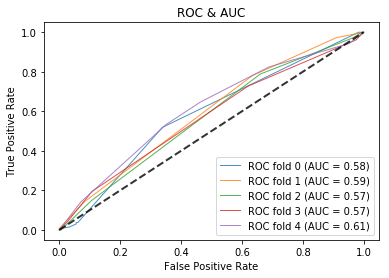

In [83]:
test_acc = []
train_acc = []

for i in range(n_folds):
#     plt.figure(figsize=(8,6))
    test_prob = riskslim_prediction(x_test_agg[i], model_information[i], subtraction_scores[i])
    train_prob = riskslim_prediction(x_train_agg[i], model_information[i], subtraction_scores[i])
    y_test, y_train = y_test_agg[i], y_train_agg[i]
    y_test[y_test == -1] = 0
    y_train[y_train == -1] = 0
    
    test_acc.append(np.mean((test_prob > 0.5) == y_test))
    train_acc.append(np.mean((train_prob > 0.5) == y_test))
    ## compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, test_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.8, 
             label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], lw=2, linestyle = '--',color='black',alpha=.8)
plt.title("ROC & AUC")
plt.legend(loc = "lower right")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
test_acc
train_acc

################

In [ ]:
#possible later implementation of nested c.v.
setup = {
    "nfolds" : 5
}

param_grid = expand_grid(params) #list of dictionaries 
nparam = len(param_grid)
i_param_best = 0
eval_varnames = dict.fromkeys(["train_auc_mean","train_auc_std","test_auc_mean","test_auc_std"])
seeds = np.random.randint(10000, size = nparam)
performance = [] #a list of dictionaries 

for i, param_dict in enumerate(param_grid): 
    #always a different set of K folds....is that okay? 
    kfold = KFold(setup["nfolds"], shuffle = True, random_state = seeds[i])
    performance.append({
        "i_param": i, 
        "seed": seeds[i]}.update(eval_varnames)
        )

    for train_inds, test_inds in kfold.split(riskslim_train['X'], riskslim_train['Y']):
        train_folds = {
            "X": riskslim_train['X'][train_inds],  #features
            "Y": riskslim_train['Y'][train_inds],  #labels
            "sample_weights":  riskslim_train['sample_weights'][train_inds],
            "variable_names":  riskslim_train['variable_names']
        }
        
        model_info, mip_info, lcpa_info = fit_riskSLIM(train_folds , param_dict)
        print_model(model_info['solution'], train_folds)
        riskslim_accuracy(X_test, Y_test, model_info, 7)
